# Salt Segmentation Using Modern Tensorflow and Keras

*Date: February 9, 2022*

This notebook is a part of the Geo2Data workshops by DS&ML in Geoscience Special Interest Group. 

We use the 2019 TGS Salt Identification Challenge data for salt body segmentation in this workshop.
This challenge took place 3 years ago and was the first of its kind for our discipline.

We will demonstrate a modern take at Tensorflow 2.5+ & Keras way to do things.

Prerequisites:
- A working Python environment (tested with `conda`), built by the provided `requirements.txt`.
- Python programming knowledge.
- Seismic data knowledge.
- Proficiency with Tensorflow and Keras.

In this notebook, we will go through the following steps:
1. Building image data loaders (as generators), provided by Keras
2. Playing around with data augmentation (in `utils.py`)
3. Tweaking Neural Network parameters (U-Net as reference)
4. Tuning optimization parameters and loss function.
5. Training a model 
6. Running predictions on test data

Let's import most of the packages we are going to use.

In [1]:
#Standard library
from os import path
import sys
import random
from itertools import repeat, islice

# Third party
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, utils, Model, optimizers, losses, regularizers, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from ipywidgets import widgets

# Configure data directories

Assuming the TGS Challenge data is downloaded in your User Downloads directory, the following paths will work. However, if you are using a custom path, please update here.

In [2]:
data_root = path.join(path.expanduser("~"), 'Downloads', 'tgs-salt-identification-challenge')
train_data_dir = path.join(data_root, 'train')
test_data_dir = path.join(data_root, 'test')

# Data Loaders and Preprocessing

We start by defining a target resolution for images.

The challenge data is 101x101 pixels. However, since we will be using pooling operations on our U-Net, we need a number constantly divisible by two. We choose 128x128 pixels.

Appropriate interpolation method will be chosen in the utility function for images, and masks.

In [3]:
HEIGHT, WIDTH = 128, 128

Now, we import the data loader convenience functions.

The `make_tf_dataflow` utility function will take user parameters and return a Tensorflow `ImageDataGenerator`.

We initialize the training samples and corresponding labels here.

We also chose to use 20% of the data as "validation", which will be used for early-stopping.

To make sure our images and labels align, we use a fixed seed value, so our data order or augmentations doesn't mix up. 

We first get them **without** augmentation.

By default, this utility function standardizes the images, but not the labels.

We divide the labels by maximum `uint16` which is 65535. This is because we want our labels to be between 0 and 1.

In [4]:
from utils import make_tf_dataflow

val_args = dict(target_size=(HEIGHT, WIDTH), seed=42, validation_split=0.2)
X_train, X_val = make_tf_dataflow(train_data_dir, 'images', **val_args)
y_train, y_val = make_tf_dataflow(train_data_dir, 'masks', **val_args, rescale=1/65535, sample_standardize=False)

# combine generators into one which yields image and masks
train_generator = zip(X_train, y_train)
val_generator = zip(X_val, y_val)

Found 3200 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.
Found 800 images belonging to 1 classes.


Now we call our plotting convenience function using image generators.

Button(description='Next Batch', style=ButtonStyle())

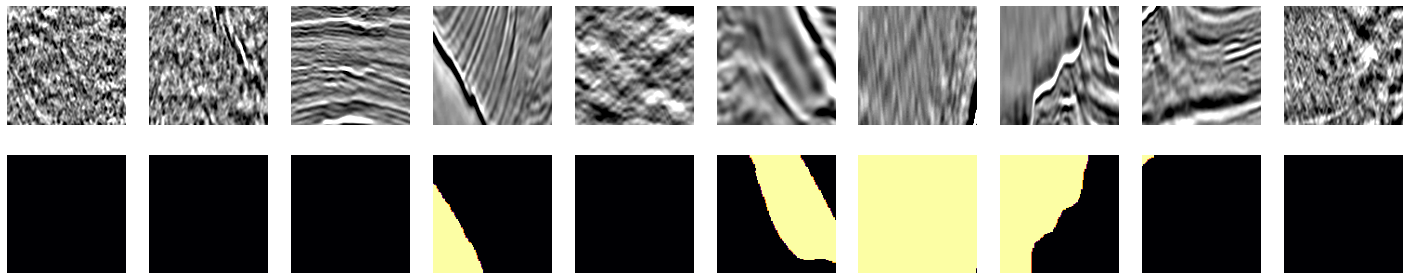

In [5]:
from utils import plot_batch

def on_button_clicked(b):
    plot_batch(*next(train_generator))
        
button = widgets.Button(description="Next Batch")
button.on_click(on_button_clicked)
display(button)

fig, ax = plot_batch(*next(train_generator))

Now that we saw our data, let's turn on augmentations.

This option turns on:
- Random horizontal flip 
- Zoom
- Shear
- Vertical/Horizontal Translation
- Rotation

The parameters are defined in the `utils` module, which can be modified.

In [6]:
X_train, X_val = make_tf_dataflow(train_data_dir, 'images', **val_args, augment=True)
y_train, y_val = make_tf_dataflow(train_data_dir, 'masks', **val_args, rescale=1/65535, sample_standardize=False, augment=True)

# combine generators into one which yields image and masks
train_generator = zip(X_train, y_train)
val_generator = zip(X_val, y_val)

Found 3200 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.
Found 800 images belonging to 1 classes.


Plotting augmented images and labels.

Button(description='Next Batch', style=ButtonStyle())

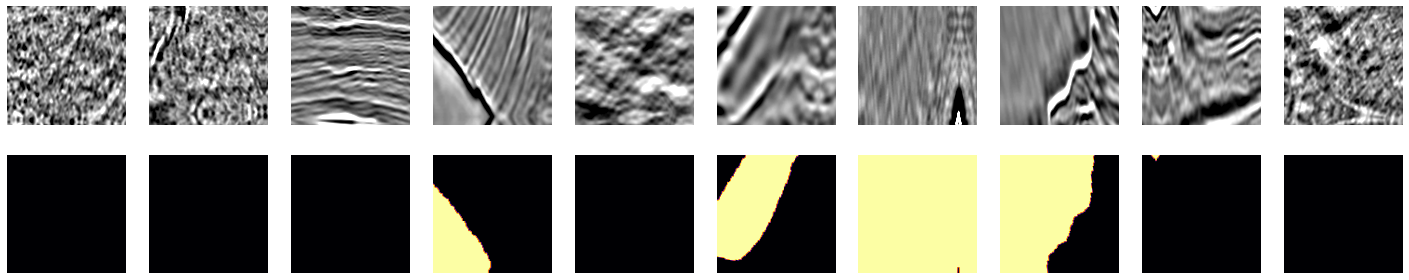

In [7]:
def on_button_clicked(b):
    plot_batch(*next(train_generator))
        
button = widgets.Button(description="Next Batch")
button.on_click(on_button_clicked)
display(button)

fig, ax = plot_batch(*next(train_generator))

# Defining the CNN

We will be using a vanilla U-Net with Batch Normalization and Average Pooling layers.

ReLU activations are a good starting point, but, more interesting activations exist.

We define our inputs, hidden layers, outputs and compile the model with the Adam optimizer with Nesterov Momentum (Nadam).

We also introduce a hybrid loss function that is based on Binary Cross Entropy and DICE loss.

In [8]:
input_img = layers.Input((HEIGHT, WIDTH, 1))

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
c1 = layers.BatchNormalization()(c1)
p1 = layers.AveragePooling2D((2, 2))(c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
c2 = layers.BatchNormalization()(c2)
p2 = layers.AveragePooling2D((2, 2))(c2)


c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
c3 = layers.BatchNormalization()(c3)
p3 = layers.AveragePooling2D((2, 2))(c3)


c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
c4 = layers.BatchNormalization()(c4)
p4 = layers.AveragePooling2D(pool_size=(2, 2))(c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
c5 = layers.BatchNormalization()(c5)

u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
c6 = layers.BatchNormalization()(c6)

u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
c7 = layers.BatchNormalization()(c7)

u8 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
c8 = layers.BatchNormalization()(c8)


u9 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)
c9 = layers.BatchNormalization()(c9)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[input_img], outputs=[outputs])

optimizer = optimizers.Nadam(learning_rate=0.002)

def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
      y_pred = tf.math.sigmoid(y_pred)
      numerator = 2 * tf.reduce_sum(y_true * y_pred)
      denominator = tf.reduce_sum(y_true + y_pred)

      return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    o = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

model.compile(optimizer=optimizer, loss=loss)
model.summary()

Metal device set to: Apple M1 Max
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 8)  32          conv2d_1[0][0]                   
____________________________________________________________

2022-02-09 00:13:39.945971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-09 00:13:39.946112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


We have ~500,000 parameters, which is reasonable for our image size. All of these parameters can be tweaked.

To see a prettier version of the CNN, we use the `plot_model` utility of Keras.

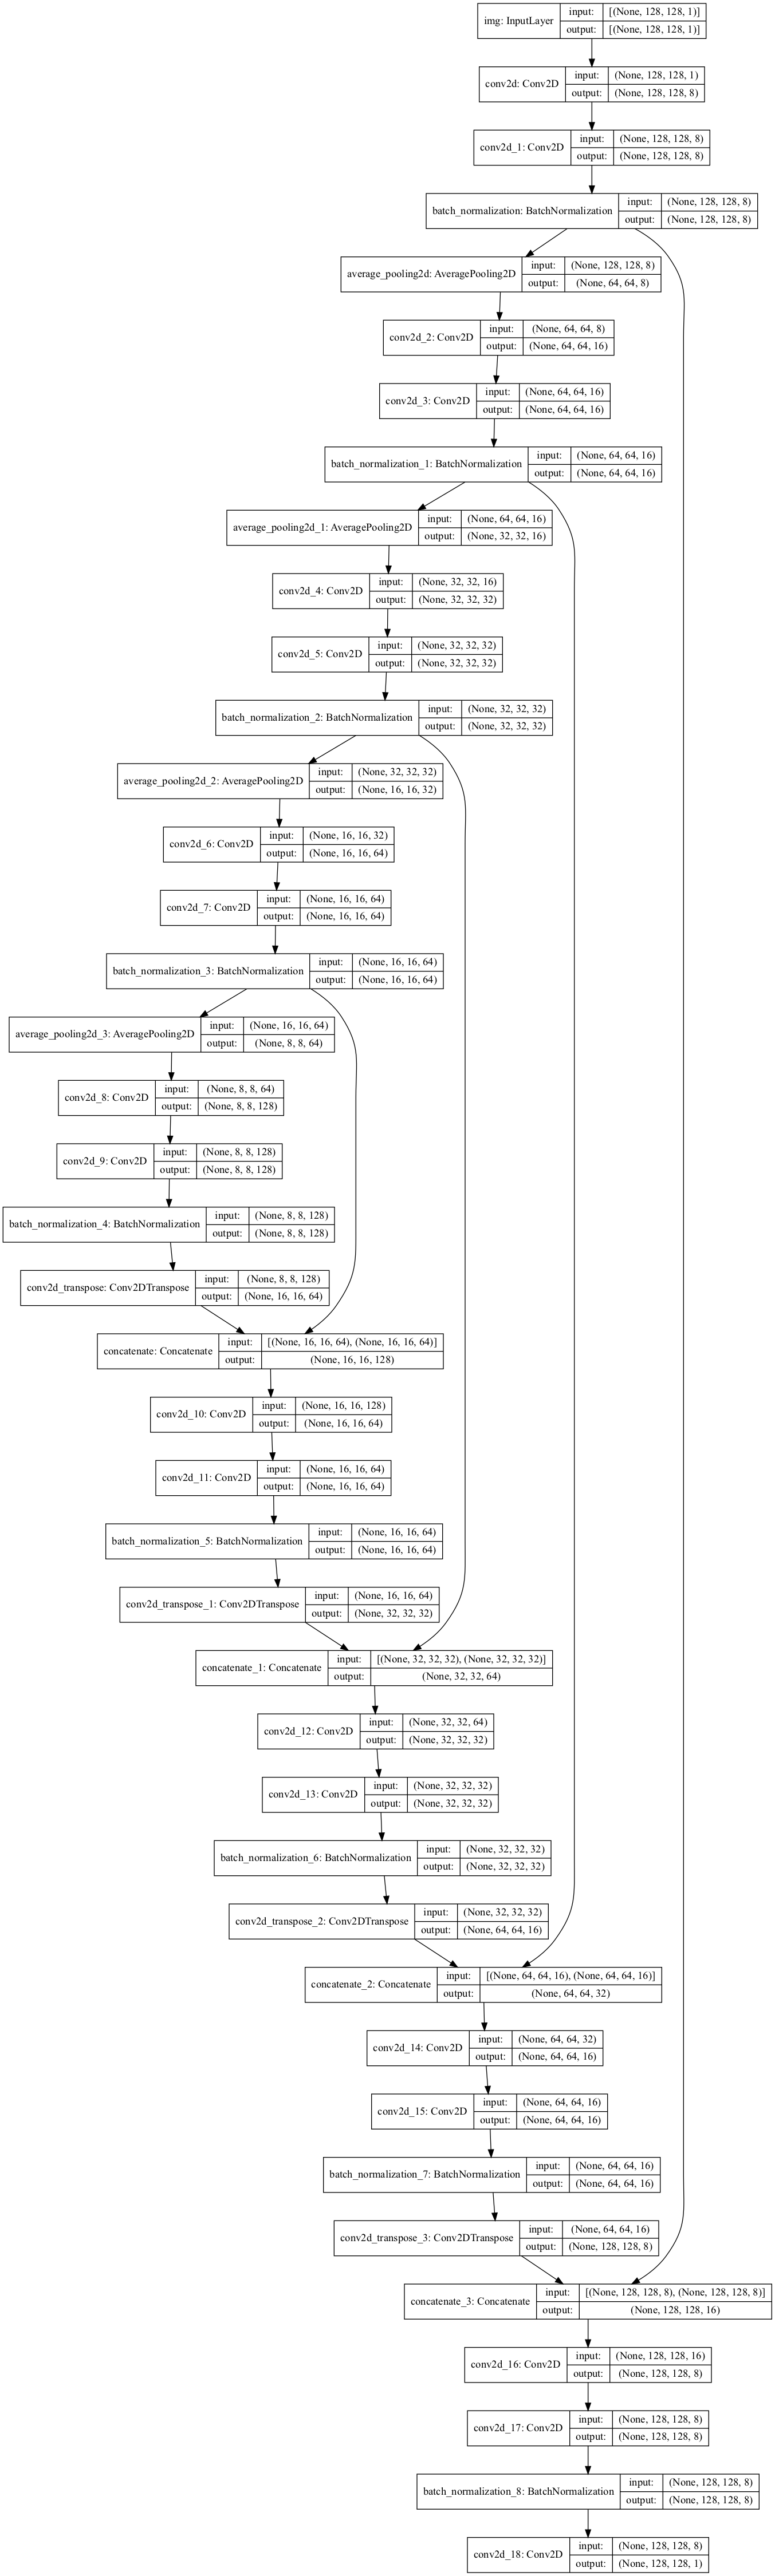

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TD')

We define some Tensorflow callbacks that stops the training if performance of the model plateaus after many iterations of learning rate decay.

We also add a model checkpointing callback so the best model gets saved.

Since we are using an "unlimited" image generator due to augmentations, we also need to specify how many steps we want to take. Or else, the training would run infinitely.

We allow it to run up to 100 epochs, however, we will see it stops earlier than that.

In [10]:
callbacks = [
    EarlyStopping(patience=11, verbose=1),
    ModelCheckpoint('tgs-salt-model.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
]

n_train = X_train.samples
n_val = X_val.samples

train_batchsize = X_train.batch_size
val_batchsize = X_val.batch_size

results = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100, 
    steps_per_epoch=n_train // train_batchsize,
    validation_steps=n_val // val_batchsize,
    callbacks=callbacks,
)

2022-02-09 00:13:40.654027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-09 00:13:40.654162: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-02-09 00:13:41.664161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.0974

2022-02-09 00:13:48.519015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 9s 77ms/step - loss: 1.0974 - val_loss: 1.2364

Epoch 00001: val_loss improved from inf to 1.23643, saving model to tgs-salt-model.h5
Epoch 2/100
100/100 [==============================] - 8s 74ms/step - loss: 0.9238 - val_loss: 1.1230

Epoch 00002: val_loss improved from 1.23643 to 1.12303, saving model to tgs-salt-model.h5
Epoch 3/100
100/100 [==============================] - 8s 76ms/step - loss: 0.8638 - val_loss: 0.9387

Epoch 00003: val_loss improved from 1.12303 to 0.93870, saving model to tgs-salt-model.h5
Epoch 4/100
100/100 [==============================] - 7s 74ms/step - loss: 0.8428 - val_loss: 0.8714

Epoch 00004: val_loss improved from 0.93870 to 0.87135, saving model to tgs-salt-model.h5
Epoch 5/100
100/100 [==============================] - 8s 75ms/step - loss: 0.8400 - val_loss: 0.9127

Epoch 00005: val_loss did not improve from 0.87135
Epoch 6/100
100/100 [==============================] - 7s 74ms/step - loss: 0.8170 - val_l

100/100 [==============================] - 8s 75ms/step - loss: 0.6885 - val_loss: 0.7981

Epoch 00049: val_loss did not improve from 0.74961

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 50/100
100/100 [==============================] - 8s 74ms/step - loss: 0.6765 - val_loss: 0.7693

Epoch 00050: val_loss did not improve from 0.74961
Epoch 51/100
100/100 [==============================] - 8s 75ms/step - loss: 0.6861 - val_loss: 0.7492

Epoch 00051: val_loss improved from 0.74961 to 0.74922, saving model to tgs-salt-model.h5
Epoch 52/100
100/100 [==============================] - 8s 77ms/step - loss: 0.6768 - val_loss: 0.7810

Epoch 00052: val_loss did not improve from 0.74922
Epoch 53/100
100/100 [==============================] - 8s 78ms/step - loss: 0.6790 - val_loss: 0.7773

Epoch 00053: val_loss did not improve from 0.74922
Epoch 54/100
100/100 [==============================] - 7s 74ms/step - loss: 0.6777 - val_loss: 0.7643

Epoch 00054: v

Now let's plot the convergence metrics and the learning rate schedule.

We get this information from the result callback of `model.fit`

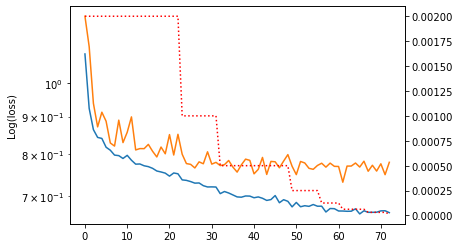

In [11]:
fig, ax = plt.subplots()
ax.semilogy(results.history['loss'])
ax.semilogy(results.history['val_loss'])
ax.set_ylabel("Log(loss)")
ax_twin = ax.twinx()
ax_twin.plot(results.history['lr'], 'r:')

Reload the lowest val_loss model back from checkpoints.

In [17]:
model.load_weights('tgs-salt-model.h5')

We now load the test data, as we did before, using the utility function.

In [18]:
test_args = dict(target_size=(HEIGHT, WIDTH))
X_test, _ = make_tf_dataflow(test_data_dir, 'images', **test_args)

Found 18000 images belonging to 1 classes.


Running predictions for test data.

In [19]:
preds_test = model.predict(X_test, verbose=1)

563/563 [==============================] - 10s 18ms/step


The test data predictions are in a numpy array. To be able to iterate together with image generator, we make a batch generator here.

In [20]:
def batcher(n, iterable):
    it = iter(iterable)
    while True:
        batch = tuple(islice(it, n))
        if not batch:
            return
        yield batch

preds_batched = batcher(X_test.batch_size, preds_test)

Now we can look at test results!

Button(description='Next Batch', style=ButtonStyle())

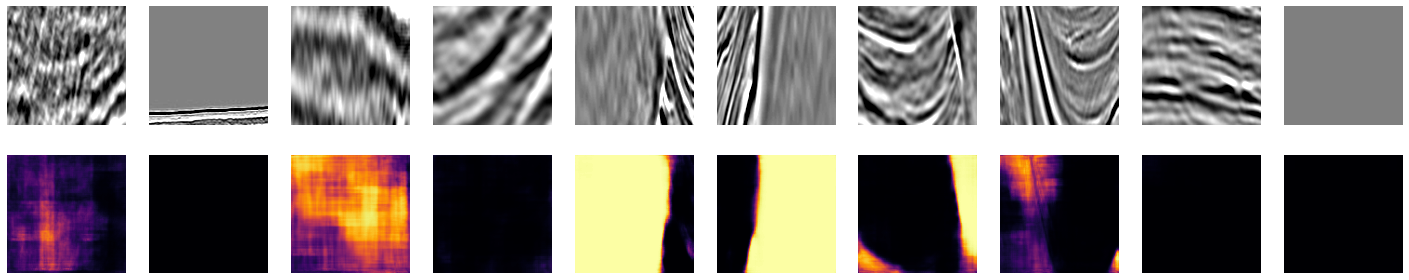

In [21]:
def on_button_clicked(b):
    plot_batch(next(X_test), next(preds_batched))
        
button = widgets.Button(description="Next Batch")
button.on_click(on_button_clicked)
display(button)

fig, ax = plot_batch(next(X_test), next(preds_batched))

We are now done with the model building, training, and a basic pipeline for augmentation.

Steps to improve this further could be:
1. Test different architectures
2. Add domain specific data augmentations or fetures (i.e. phase shift, filtering, relative impedance, etc.)
3. Fine tune parameters of this model
4. Generate multiple models and ensemble the results
5. Condition and threshold the probabilities
6. And more, up to your imagination!

Thanks for joining us!